In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Cargar tu DataFrame
df = pd.read_csv('/content/data_file.csv')

# Definir la semilla para que la división sea reproducible
semilla = 42

# Dividir los datos en conjuntos de entrenamiento y prueba
data_train, data_test = train_test_split(df, test_size=0.2, random_state=semilla)

# Separar las columnas relevantes para entrenamiento y prueba
X_train = data_train['reviewText']
X_test = data_test['reviewText']
y_train = data_train['binaria']
y_test = data_test['binaria']

# Comprobar las dimensiones de los conjuntos resultantes
print("Dimensiones de data_train:", X_train.shape)
print("Dimensiones de data_test:", X_test.shape)


Dimensiones de data_train: (48021,)
Dimensiones de data_test: (12006,)


In [2]:
# RegEx for removing non-letter characters
import re

# NLTK library for the remaining steps
import nltk
nltk.download("stopwords")   # download list of stopwords (only once; need not run it again)
from nltk.corpus import stopwords # import stopwords

from nltk.stem import PorterStemmer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
!pip install num2words


In [4]:
import os
import pickle
import unicodedata
from num2words import num2words
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

cache_dir = os.path.join("cache", "vehicle_analysis")
os.makedirs(cache_dir, exist_ok=True)

def nltk_cleaner(text, tokenizer, sw_list, stemmer):
    clean_text = list()

    # Eliminar acentos, etc
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # Separar palabras eliminando signos de puntuación
    for word in tokenizer.tokenize(text):

        # Eliminar stop words
        if word not in sw_list:

            # Eliminar espacios sobrantes, convertir a minúsculas y aplicar stemming
            clean_word = stemmer.stem(word).lower().strip()

            # Convertir dígitos a palabras
            if clean_word.isdigit():
                clean_word = num2words(clean_word, lang='en')  # Cambiado a inglés

            clean_text.append(clean_word)

    clean_text = ' '.join(clean_text)

    return clean_text

def preprocess_data(X_train, X_test, y_train, y_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert reviews to preprocessed words; read from cache if available."""

    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass

    if cache_data is None:
        tokenizer = RegexpTokenizer(r'\w+')
        sw_list = stopwords.words('english')
        stemmer = PorterStemmer()

        words_train = [nltk_cleaner(review, tokenizer, sw_list, stemmer) for review in X_train]
        words_test = [nltk_cleaner(review, tokenizer, sw_list, stemmer) for review in X_test]

        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test, y_train=y_train, y_test=y_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        words_train, words_test, y_train, y_test = (cache_data['words_train'], cache_data['words_test'],
                                                    cache_data['y_train'], cache_data['y_test'])

    return words_train, words_test, y_train, y_test

# Uso de la función con tus datos
X_train_preprocess, X_test_preprocess, y_train_preprocess, y_test_preprocess = preprocess_data(X_train, X_test, y_train, y_test)

print("\n--- Raw review ---")
print(X_train_preprocess[0])
print("\n--- Preprocessed words ---")
print(X_train_preprocess[0])
print("\n--- Label ---")
print(y_train_preprocess[0])


Read preprocessed data from cache file: preprocessed_data.pkl

--- Raw review ---
thirteen year two hundred and forty zero mile still run handl like new truck half afraid buy new one not sure i got except one million gener good but love truck

--- Preprocessed words ---
thirteen year two hundred and forty zero mile still run handl like new truck half afraid buy new one not sure i got except one million gener good but love truck

--- Label ---
0


In [5]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import joblib
import random

def extract_BoW_features(X_train, X_test, vocabulary_size=5000,
                         cache_dir=cache_dir, cache_file="bow_features.pkl"):
    """Extract Bag-of-Words for a given set of documents, already preprocessed into words."""

    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass

    if cache_data is None:
        vectorizer = CountVectorizer(max_features=vocabulary_size, stop_words='english')
        features_train = vectorizer.fit_transform(X_train).toarray()
        features_test = vectorizer.transform(X_test).toarray()

        if cache_file is not None:
            vocabulary = vectorizer.get_feature_names_out()
            cache_data = dict(features_train=features_train, features_test=features_test,
                             vocabulary=vocabulary)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                joblib.dump(cache_data, f)
            print("Wrote features to cache file:", cache_file)
    else:
        features_train, features_test, vocabulary = (cache_data['features_train'],
                cache_data['features_test'], cache_data['vocabulary'])

    return features_train, features_test, vocabulary

features_train, features_test, vocabulary = extract_BoW_features(X_train_preprocess, X_test_preprocess)

print("Vocabulary: {} words".format(len(vocabulary)))

# Convertir la lista en una tupla para sample
vocabulary_tuple = tuple(vocabulary)
sample_words = random.sample(vocabulary_tuple, 8)
print("Sample words: {}".format(sample_words))

print("\n--- Bag-of-Words features ---")
print(features_train[5])
print("\n--- Label ---")
print(y_train[5])


Read features from cache file: bow_features.pkl
Vocabulary: 5000 words
Sample words: ['strength', 'grandfath', 'carpool', 'lifetim', 'quickest', 'european', 'clone', 'pick']

--- Bag-of-Words features ---
[0 0 0 ... 0 0 0]

--- Label ---
0


Se elige un vocabularia grande ya que hay unas 48021 muestras en test asi que elejo un valor alto.

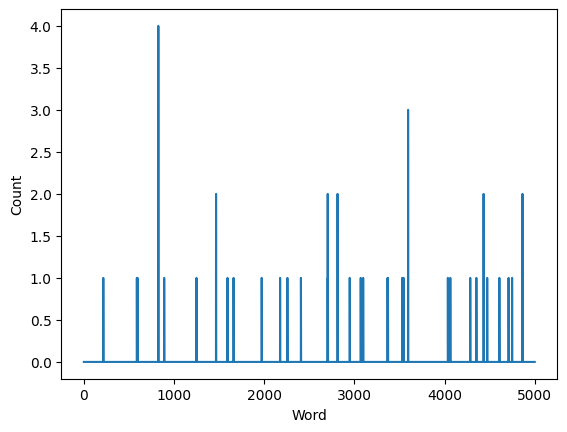

In [6]:
import matplotlib.pyplot as plt
#Frecuencia de las palabras. Observamos algunos outliers.
#Esos datos tienen q ser significativos dado que se ha realizado un preprocesamiento previo
plt.plot(features_train[4999,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

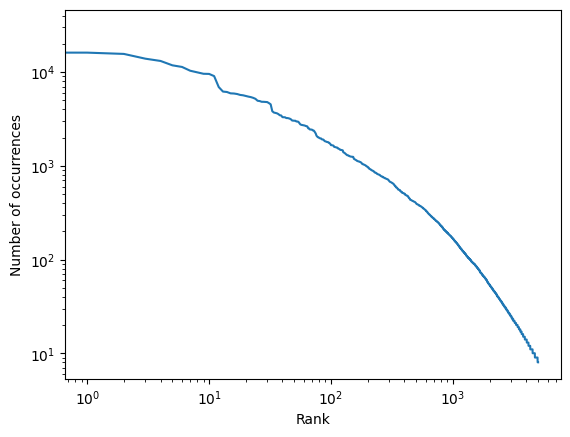

In [7]:
#Observamos la ley de Zipf
word_freq = features_train.sum(axis=0)

sorted_word_freq = np.sort(word_freq)[::-1]

plt.plot(sorted_word_freq)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('Rank')
plt.ylabel('Number of occurrences')
plt.show()

In [8]:
import sklearn.preprocessing as pr

features_train = pr.normalize(features_train, axis=1)
features_test = pr.normalize(features_test, axis=1)

No se ha justificado la aplicacion del preprocesado por que ya se vio como era necesario en la exploracion del corpus.

**Entrenar con GradientBoostingClassifier**

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

n_estimators = 32

def classify_gboost(X_train, X_test, y_train, y_test):
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=1.0, max_depth=1, random_state=42)
    clf.fit(X_train, y_train)

    print("[{}] Accuracy: train = {}, test = {}".format(
            clf.__class__.__name__,
            clf.score(X_train, y_train),
            clf.score(X_test, y_test)))

    return clf


clf2 = classify_gboost(features_train, features_test, y_train_preprocess, y_test_preprocess)

[GradientBoostingClassifier] Accuracy: train = 0.9085816621894588, test = 0.910128269198734


[GradientBoostingClassifier] Accuracy: train = 0.9086, test = 0.9101
Confusion Matrix:
[[   97  1017]
 [   62 10830]]
Recall: 0.9943
Precision: 0.9142
F1-Score: 0.9525
AUC-ROC: 0.5539


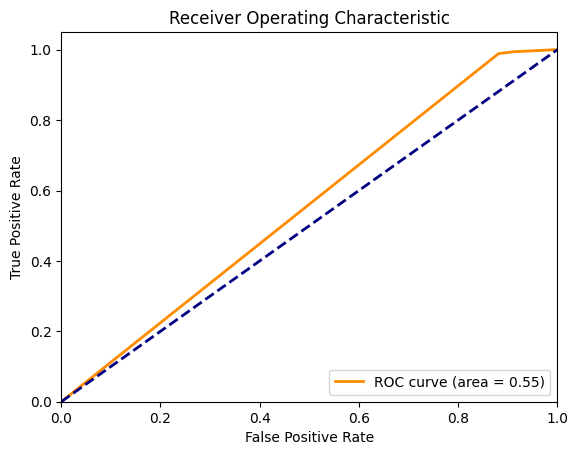

In [23]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

n_estimators = 32

def classify_gboost(X_train, X_test, y_train, y_test):
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=1.0, max_depth=1, random_state=42)
    clf.fit(X_train, y_train)

    train_accuracy = clf.score(X_train, y_train)
    test_accuracy = clf.score(X_test, y_test)

    print("[{}] Accuracy: train = {:.4f}, test = {:.4f}".format(
            clf.__class__.__name__,
            train_accuracy,
            test_accuracy))

    # Calcula la matriz de confusión en el conjunto de prueba
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Calcula el Recall en el conjunto de prueba
    recall = recall_score(y_test, y_pred)
    print("Recall: {:.4f}".format(recall))

    # Calcula la Precisión en el conjunto de prueba
    precision = precision_score(y_test, y_pred)
    print("Precision: {:.4f}".format(precision))

    # Calcula el F1-Score en el conjunto de prueba
    f1 = f1_score(y_test, y_pred)
    print("F1-Score: {:.4f}".format(f1))

    # Calcula el AUC-ROC en el conjunto de prueba
    y_scores = clf.decision_function(X_test)
    roc_auc = roc_auc_score(y_test, y_scores)
    print("AUC-ROC: {:.4f}".format(roc_auc))

    # Calcula la curva ROC y plótala
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    return clf

clf2 = classify_gboost(features_train, features_test, y_train_preprocess, y_test_preprocess)


En este caso obtenemos valores altos de accuracy  del modelo de clasificacion aunque esta metrica podria ser enganosa ya que los datos usados no estan balanceados. Por eso a  continuacion se agregan otras metricas:

*   matriz de confusion:
97 verdaderos negativos (TN): Muestras clasificadas correctamente como negativas.
1017 falsos positivos (FP): Muestras clasificadas incorrectamente como positivas.
62 falsos negativos (FN): Muestras clasificadas incorrectamente como negativas.
10830 verdaderos positivos (TP): Muestras clasificadas correctamente como positivas.

El modelo tiene un buen número de verdaderos positivos (valor alto de Recall) y verdaderos negativos, lo que muestra su capacidad para clasificar correctamente tanto las muestras positivas como las negativas. Sin embargo, también hay un número considerable de falsos positivos (valor que se deberia mejorar Precision) y falsos negativos, lo que sugiere que el modelo todavía comete errores y podría mejorarse, especialmente en la reducción de los falsos positivos y falsos negativos para mejorar la precisión y la recuperación.
F1-Score sugiere que el modelo tiene un buen rendimiento equilibrado en términos de Recall y Precision
*   AUC-ROC muestra la capacidad del modelo de distinguir entre clases donde el valor esta mas cerca del 0.5 (azar). Es bastante bajo lo que significa que no tiene una buena capacidad de discriminar entre clases y esto se deberia al debalance y sobreajustamiento. Necesita mejorar el preprocesamiento con un mejor balance y trabajar con un GridSearchCV con los distintos hyperparametros.








In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

def classify_gboost(X_train, X_test, y_train, y_test):
    # Define los parámetros a ajustar
    param_grid = {
        'n_estimators': [10, 20, 30, 40],
        'learning_rate': [0.1, 0.5, 1, 2],
        'max_depth': [1, 3, 5, 8]
    }

    # Crea el modelo GradientBoostingClassifier
    clf = GradientBoostingClassifier(random_state=42)

    # Crea el objeto GridSearchCV
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5)

    # Ajusta el modelo a los datos de entrenamiento
    grid_search.fit(X_train, y_train)

    # Obtiene los mejores hiperparámetros encontrados
    best_params = grid_search.best_params_
    print("Mejores hiperparámetros:", best_params)

    # Entrena un modelo con los mejores hiperparámetros en todo el conjunto de entrenamiento
    clf_best = GradientBoostingClassifier(random_state=42, **best_params)
    clf_best.fit(X_train, y_train)

    # Calcula y muestra las métricas
    train_accuracy = clf_best.score(X_train, y_train)
    test_accuracy = clf_best.score(X_test, y_test)

    print("[GradientBoostingClassifier] Accuracy: train = {:.4f}, test = {:.4f}".format(
        train_accuracy, test_accuracy))

    # Calcula la matriz de confusión en el conjunto de prueba
    y_pred = clf_best.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Calcula el Recall en el conjunto de prueba
    recall = recall_score(y_test, y_pred)
    print("Recall: {:.4f}".format(recall))

    # Calcula la Precisión en el conjunto de prueba
    precision = precision_score(y_test, y_pred)
    print("Precision: {:.4f}".format(precision))

    # Calcula el F1-Score en el conjunto de prueba
    f1 = f1_score(y_test, y_pred)
    print("F1-Score: {:.4f}".format(f1))

    # Calcula el AUC-ROC en el conjunto de prueba
    y_scores = clf_best.decision_function(X_test)
    roc_auc = roc_auc_score(y_test, y_scores)
    print("AUC-ROC: {:.4f}".format(roc_auc))

    # Calcula la curva ROC y plótala
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    return clf_best

# Llama a la función classify_gboost con tus datos
best_clf = classify_gboost(features_train, features_test, y_train_preprocess, y_test_preprocess)



Se intento ejecutar pero tardaba mucho la ejecucion asi que la idea seria si hubiese mas tiempo lanzar lo y esperar a que nos de los mejores hiperparametros con los mejores resultado siembre teniendo en cuenta que es un dataset no balanceado.

**Entrenamiento** **con dethlearning**


In [9]:
# Media de palabras en la reviews.
# RRN necesitamos establcer el tamaño de neruonas
# primero hacer el análisis para ver el número medio y máxcimo de palabras en las revies.
#si una frase se queda corta, la palabrs restantes se rellenaran de 0. Esto sería negativop
max = 0
mean = []
for example in X_train_preprocess:
  length = len(example)
  mean.append(len(example))
  if length > max:
    max = length
print(sum(mean) / len(mean))
print(max)

168.68603319381103
11312


In [10]:
from tensorflow.keras.utils import pad_sequences

max_words = 500

In [11]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, GRUV2, SimpleRNN
vocabulary_size = 5000
embedding_size = 32
model = Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           160000    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Define la función para calcular y mostrar las métricas de evaluación
def evaluate_model_metrics(model, X_test, y_test):
    # Calcula las probabilidades de predicción en el conjunto de prueba
    y_pred_prob = model.predict(X_test)

    # Convierte las probabilidades en etiquetas binarias usando un umbral de 0.5
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Calcula la matriz de confusión
    confusion = confusion_matrix(y_test, y_pred)

    # Calcula y muestra las métricas de evaluación
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)

    print("Accuracy:", accuracy)
    print("Confusion Matrix:")
    print(confusion)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("AUC-ROC:", roc_auc)

    # Calcula y plotea la curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

# Divide features_train en conjuntos de entrenamiento y validación (90% entrenamiento, 10% validación)
X_train_partial, X_valid, y_train_partial, y_valid = train_test_split(
    features_train, y_train_preprocess, test_size=0.1, random_state=42
)
num_epochs = 1
batch_size = 64
max_words = 500

# Ajusta este valor según la longitud deseada de las secuencias
X_train_partial = pad_sequences(X_train_partial, maxlen=max_words)
X_valid = pad_sequences(X_valid, maxlen=max_words)

# Define una función de devolución de llamada para guardar el modelo con la mejor precisión en validación
model_checkpoint = ModelCheckpoint(
    "best_model.h5",  # Nombre del archivo para guardar el modelo
    monitor='val_accuracy',  # Métrica a monitorear (precisión en validación)
    save_best_only=True,  # Guardar solo el mejor modelo
    mode='max',  # Maximizar la métrica de validación
    verbose=1
)

# Entrena el modelo con el conjunto de entrenamiento y validación
history = model.fit(
    X_train_partial,
    y_train_partial,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[model_checkpoint]  # Usa la función de devolución de llamada para guardar el mejor modelo
)



676/676 [==============================] - ETA: 0s - loss: 0.3137 - accuracy: 0.9055
Epoch 1: val_accuracy improved from -inf to 0.90964, saving model to best_model.h5
676/676 [==============================] - 617s 912ms/step - loss: 0.3137 - accuracy: 0.9055 - val_loss: 0.3051 - val_accuracy: 0.9096


376/376 [==============================] - 48s 127ms/step
Accuracy: 0.9072130601365984
Confusion Matrix:
[[    0  1114]
 [    0 10892]]
Precision: 0.9072130601365984
Recall: 1.0
F1-Score: 0.9513494628351822
AUC-ROC: 0.5003570225309897


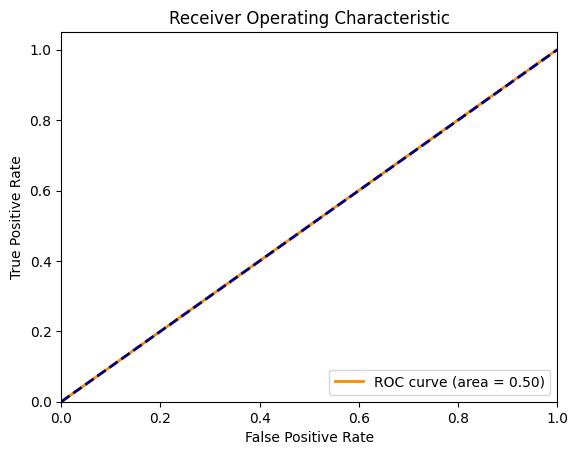

In [16]:

# Evalúa el modelo en el conjunto de prueba y muestra las métricas de evaluación
X_test = pad_sequences(features_test, maxlen=max_words)
y_test = y_test_preprocess
evaluate_model_metrics(model, X_test, y_test)

Se puede ver que tiene un acuraci del 90,72%  con el conjunto de validacion. Aunque como se ve en la matriz de confusion el conjunto de datos despues de una epoca  el modelo no es capaz de predecir la clase binaria de 0 (evaluaciones negativas asociadas a las estrellas de 1 al 3). Pero ha predicho correctamente 10,892 muestras como Clase 1 (estrellas 4 y 5). Esto es debido a que necesitemos mas kdatos de la clase 0 o emplear tecnicas de equilibrio. Esto tambien se puede ver en AUC-ROC de aproximadamente 0.5004 indica que el modelo no es efectivo para discriminar entre las clases 0 y 1 en este problema de clasificación. En concusion se deberia explorar mas en los hiperparametros de este modelo y entrenar por mas tiempo con una base de datos balanceada.





Los dos modelos empleados muestran los mismo resultados, asi que como ya se  ha comentadose deberia seguir los los 3 puntos principales como balancear los datos, incrementar el training y selecionar los hiperparametros para tener un buen modelo capaz de clasificar correctamente teniendo una descripicon de una reseña.